## Construindo árvores de decisão, do mais simples a mais robustas, como o Random Force.
### Alura</br> Instrutora - Thainá </br> Data - 24/02/2023

#### O algoritmo mais popular e mais clássico para construir árvore de decisão é chamado de CART, que em português seria “árvore de classificação e regressão”. A decisão do melhor nó é feita a partir do cálculo do índice de impureza Gini (existem outros índices como o entropi), que é um uns dos índices, uma das métricas mais populares para fazer esse cálculo, enquanto menor o índice de impureza melhor é o nó.

### A base de dados [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) é uma base de dados com dados reais, tem aproximadamente 284 mil transações, que foram feitas durante 2 dias de uma determinada empresa de cartão de crédito.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import graphviz

In [2]:
SEED = 0

In [3]:
# link_dados = 'https://caelum-online-public.s3.amazonaws.com/1799-xgboost/02/creditcard.csv'

df_fraude = pd.read_csv('creditcard.csv')
df_fraude.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* Temos o atributo Time - que é o tempo contado a partir da primeira transação desse grupo, percebemos que está na ordem, então a partir dessa primeira transação número 0, quanto tempo passou para as próximas transações.
* E o atributo Amount - é o valor daquela transação específica.

### Análise exploratória

In [4]:
df_fraude.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [5]:
quantidades = df_fraude.Class.value_counts()

print(f'Total de transações - {df_fraude.shape[0]}')
print(f'Total de transações normais - {quantidades[0]}, representa {((quantidades[0]/df_fraude.shape[0])*100):.3f}% do tatao de transações')
print(f'Total de fraudes - {quantidades[1]}, representa {((quantidades[1]/df_fraude.shape[0])*100):.3f}% do tatao de transações')

Total de transações - 284807
Total de transações normais - 284315, representa 99.827% do tatao de transações
Total de fraudes - 492, representa 0.173% do tatao de transações


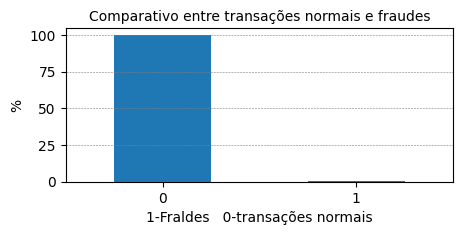

In [6]:
plt.figure(figsize=(5, 2))
plt.title("Comparativo entre transações normais e fraudes", fontsize=10, pad=5)
df_fraude.Class.value_counts(normalize=True).mul(100).plot(kind='bar', rot=0)
plt.grid(axis='y', linestyle='--', linewidth=0.4, color='gray')
plt.xlabel("1-Fraldes   0-transações normais")
plt.ylabel("%")
plt.show()

Temos então muito pouco de uma classe, ou seja, nossa classe de fraude, por outro lado temos muito, quase tudo, da outra classe, ou seja, nossa classe de transações normais. Isso torna esses dados o que chamamos de dados desbalanceados, eles seriam balanceados se tivéssemos metade das transações com fraudes e metade das transações sem fraude. Isso seriam dados balanceados.

### Separação dos dados para treino e teste

In [7]:
X = df_fraude.drop('Class', axis='columns')
y = df_fraude[['Class']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y ,random_state=SEED)

### Realização do treino do modelo

#### Cross Validate
O cross validate divide a base de dados de forma determinística, sem aleatoriedade.

#### StratifiedKFold
O StratifiedKFold permite dividir a base de dados com embaralhamento e estratificado, importante para garantir que a base de treino sempre tenha dados de fraude.</br>
Não permite agrupar por categorias, fazendo com que uma mesma categoria esteja na base de treino e teste.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' alt="Como funciona o cross validate" width="600" height="350"> </img>

In [9]:
def calcula_intervao_confianca(scores):
    media = scores['test_score'].mean()
    desvio_padrao = scores['test_score'].std()
    intervalo_confiança = ((media-2*desvio_padrao) * 100, (media+2*desvio_padrao) * 100) 

    print(f'A quantidade de splits é de {len(scores["test_score"])} folds')
    print(f'A média dos scores é de {media:.5f}')
    print(f'O desvio padrão é de {desvio_padrao}')
    print(f'O intervalo de confiança ficou entre {intervalo_confiança[0]:.2f}% e {intervalo_confiança[1]:.2f}%')

In [10]:
def treinamento_modelo(modelo, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    scores = cross_validate(modelo, X, y, cv=cv)

    for tipo in scores:
        print(f'{tipo}: {scores[tipo]}')

    print()

    calcula_intervao_confianca(scores)

In [11]:
tree_classifier = DecisionTreeClassifier()

treinamento_modelo(tree_classifier, X_test, y_test)

fit_time: [1.27673531 1.14999676 1.54375553 1.3088448  1.30771661]
score_time: [0.00300217 0.         0.00400233 0.00399351 0.00299621]
test_score: [0.99789363 0.99877107 0.99824438 0.99859551 0.99877107]

A quantidade de splits é de 5 folds
A média dos scores é de 0.99846
O desvio padrão é de 0.0003403049127975605
O intervalo de confiança ficou entre 99.78% e 99.91%


### Visualizando arvore gerada

In [12]:
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

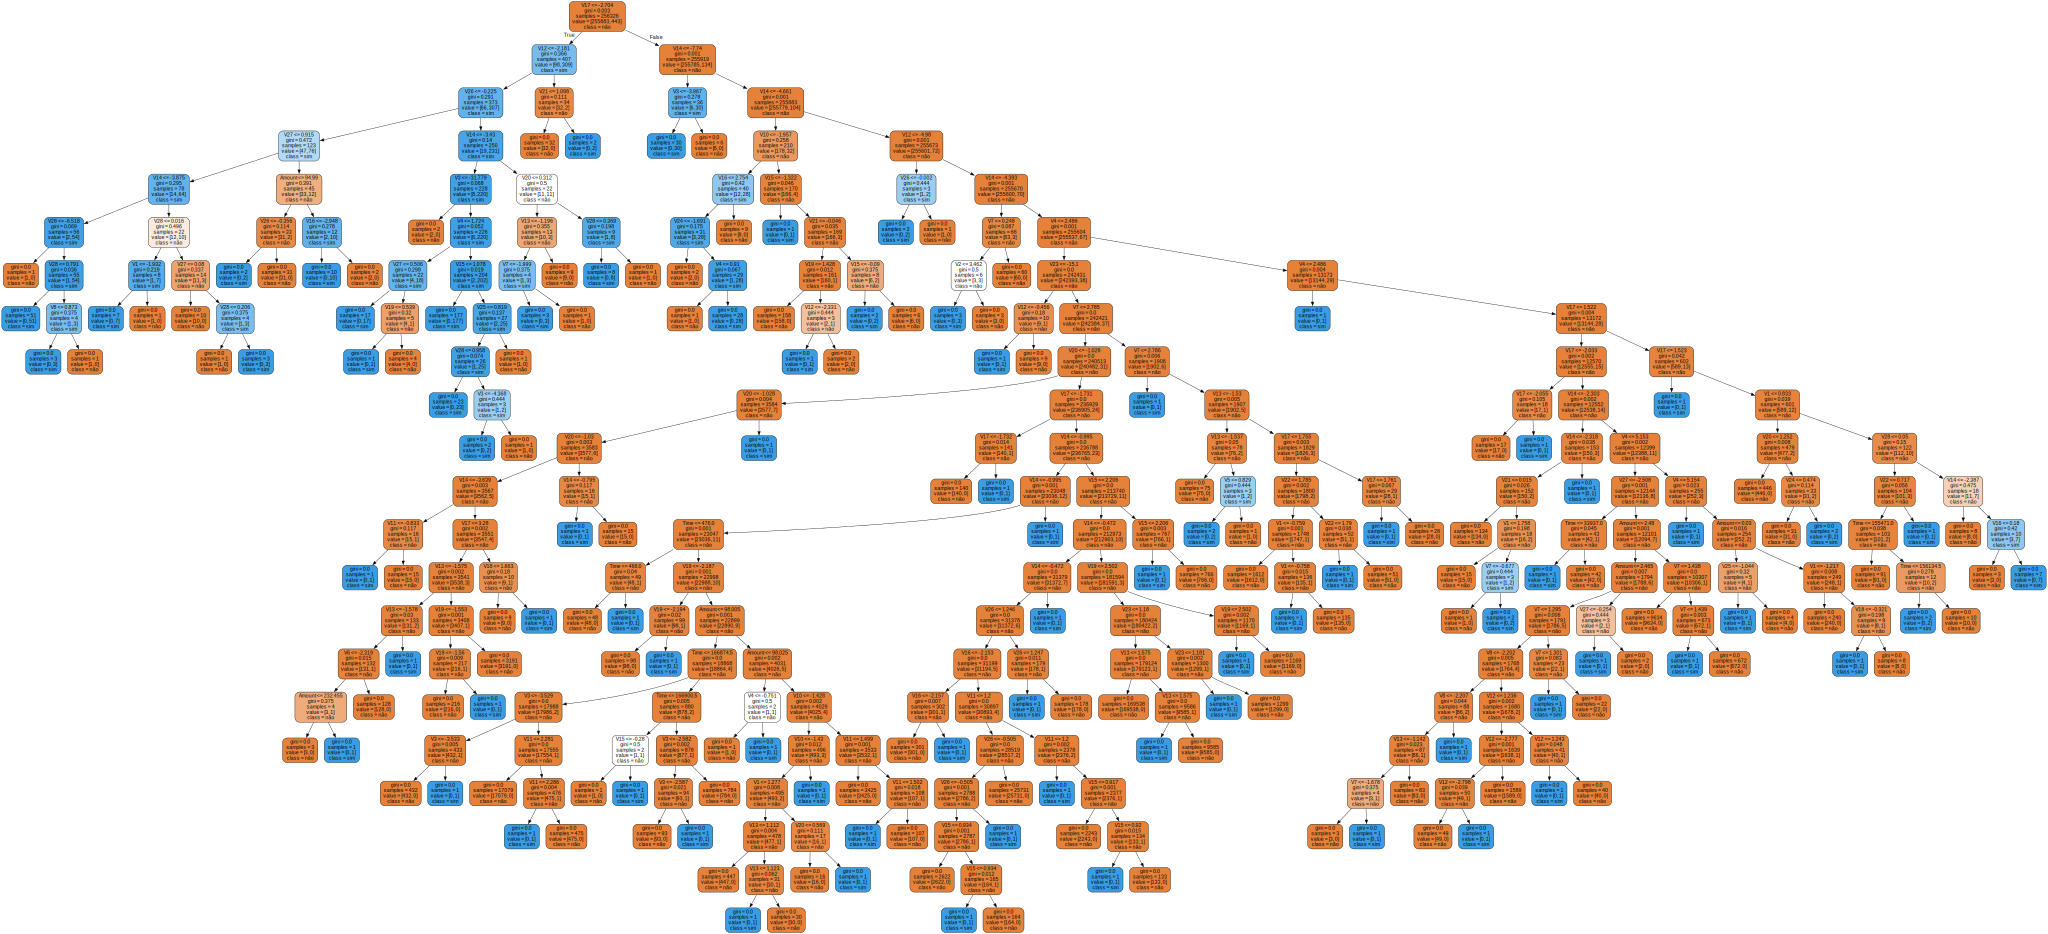

In [13]:
# out_file=None - sem arquivo de saída
# filled=True - preecher os retângulos
# rounded=True - redondos
# class_names=["não", "sim"] - nomes das classes não vendido, sim vendido
# feature_names=features - nomes das colunas de X

def visualizar_arvore(tree_classifier):
    features = X.columns
    dot_data = export_graphviz(tree_classifier, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)

    graph = graphviz.Source(dot_data)
    return graph

graph = visualizar_arvore(tree_classifier)
graph

### Avaliação do modelo sobre os dados de teste

Acurácia

Matriz de Confusão

Métrica Precisão</br>
Importante quando lidamos com dados desbalanceados.</br>
É calculada a partir do número de previsões como fraude corretamente dividido pelo número total de transações previstas como fraude.</br>
obs: Se o modelo tivesse previsto somente <u>uma transação como fraude corretamente</u>, a <u>precisão seria de 100%</u>, podendo causar uma interpretação errada.

Métrica Recall</br>
Para corrigir o problema de interpretação da precisão de 100% a Precisão sempre é calculada juntamente com o Recall</br>
Ela indica o quanto nosso modelo está identificando os casos positivos de fraude corretamente.</br>
É utilizada para indicar a relação entre as previsões positivas de fraude realizadas corretamente e todas as transações que realmente são fraude.

In [14]:
y_pred = tree_classifier.predict(X_test)

In [15]:
class_names = ['Transação normal', 'Fraude']

def avaliacao_arvore(y_test, y_pred):
    # Calcula a matriz de confusão
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf_table = pd.DataFrame(data=cnf_matrix, index=class_names, columns=[x + "(prev)" for x in class_names])
    display(cnf_table)

    # Acurácia
    acuracia = accuracy_score(y_test, y_pred)
    print(f'Acúrácia sobre os dados de teste - ({cnf_matrix[0, 0]} + {cnf_matrix[1, 1]}) / {cnf_matrix.sum()} =  {(acuracia*100):.4f}%')

    # Precisão
    precisao = precision_score(y_test, y_pred)
    print(f'Precisão somente para as transações com fraude - {cnf_matrix[1, 1]} / ({cnf_matrix[0, 1]} + {cnf_matrix[1, 1]}) = {(precisao*100):.4f}%') 

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f'Recall somente para as transações com fraude - {cnf_matrix[1, 1]} / ({cnf_matrix[1, 0]} + {cnf_matrix[1, 1]}) =  {(recall*100):.4f}%') 

In [16]:
avaliacao_arvore(y_test, y_pred)

,Transação normal(prev),Fraude(prev)
Transação normal,28421,11
Fraude,14,35


Acúrácia sobre os dados de teste - (28421 + 35) / 28481 =  99.9122%
Precisão somente para as transações com fraude - 35 / (11 + 35) = 76.0870%
Recall somente para as transações com fraude - 35 / (14 + 35) =  71.4286%


In [17]:
print(f'Parêmetros utilizados para contrução do modelo: {tree_classifier.get_params()}', end='\n\n')
print(f'Profundudade da árvore gerada: {tree_classifier.get_depth()}')

Parêmetros utilizados para contrução do modelo: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Profundudade da árvore gerada: 21


A profundidade da árvore não foi limiteda e ficou muito grande, quando isso ocorre é possível que cause overffiting, que é quando o modelo fica muito especializado aos dados de treinamento e perde a capacidade de generalização para novos dados.

### Refinando o modelo

* Profundidade máxima ( max_depth=10 )

In [18]:
tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=SEED)

treinamento_modelo(tree_classifier, X_train, y_train)

fit_time: [13.33314633 13.50583982 12.16851401 11.60631943 12.01631331]
score_time: [0.01897812 0.0320003  0.01577592 0.01575351 0.01599717]
test_score: [0.99953185 0.99933678 0.99933678 0.9993953  0.99941481]

A quantidade de splits é de 5 folds
A média dos scores é de 0.99940
O desvio padrão é de 7.151524661047212e-05
O intervalo de confiança ficou entre 99.93% e 99.95%


In [19]:
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)
avaliacao_arvore(y_test, y_pred)

,Transação normal(prev),Fraude(prev)
Transação normal,28430,2
Fraude,13,36


Acúrácia sobre os dados de teste - (28430 + 36) / 28481 =  99.9473%
Precisão somente para as transações com fraude - 36 / (2 + 36) = 94.7368%
Recall somente para as transações com fraude - 36 / (13 + 36) =  73.4694%


* Número mínimo de instâncias em cada folha - ( min_samples_leaf=10 )

In [20]:
tree_classifier = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=SEED)

treinamento_modelo(tree_classifier, X_train, y_train)

fit_time: [11.82724476 11.89196754 12.0881269  11.41069865 11.61783576]
score_time: [0.01484013 0.01502728 0.01641703 0.01664329 0.01680756]
test_score: [0.99945383 0.99943431 0.99943431 0.99931727 0.99937579]

A quantidade de splits é de 5 folds
A média dos scores é de 0.99940
O desvio padrão é de 5.026684812400055e-05
O intervalo de confiança ficou entre 99.93% e 99.95%


In [21]:
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)
avaliacao_arvore(y_test, y_pred)

,Transação normal(prev),Fraude(prev)
Transação normal,28426,6
Fraude,12,37


Acúrácia sobre os dados de teste - (28426 + 37) / 28481 =  99.9368%
Precisão somente para as transações com fraude - 37 / (6 + 37) = 86.0465%
Recall somente para as transações com fraude - 37 / (12 + 37) =  75.5102%


### Ensemble Learning

#### RandomForestClassifier
O algoritimo random forest utiliza a técnica bagging, que significa bootstrapping aggregating:
* bootstrapping sampling - Dividir a base de dados em algumas amostras que seja representativa e independente, gerando várias árvores.
* aggregating - juntar todos os modelos gerados para chegar em um valor final, como por exemplo eleger o valor com maior quantidade de votos.</br>

A validação é feita com as instâncias que não pertenceram as amostras de teste, chamadas de instâncias out of bag.</br>
A métrica de avaliação será o erro out of bag


In [22]:
%%time
rand_tree_classifier = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=SEED)

treinamento_modelo(rand_tree_classifier, X_train, np.array(y_train).ravel())

fit_time: [102.32248592  99.5217793  105.50368547 100.47620511 104.68883777]
score_time: [0.26399946 0.23922563 0.22223234 0.23758006 0.26700234]
test_score: [0.99959037 0.99953184 0.99951234 0.99951234 0.99960987]

A quantidade de splits é de 5 folds
A média dos scores é de 0.99955
O desvio padrão é de 4.091867383828885e-05
O intervalo de confiança ficou entre 99.95% e 99.96%
CPU times: total: 8min 5s
Wall time: 8min 33s


In [23]:
rand_tree_classifier.fit(X_train, np.array(y_train).ravel())
y_pred = rand_tree_classifier.predict(X_test)
avaliacao_arvore(y_test, y_pred)

,Transação normal(prev),Fraude(prev)
Transação normal,28431,1
Fraude,12,37


Acúrácia sobre os dados de teste - (28431 + 37) / 28481 =  99.9544%
Precisão somente para as transações com fraude - 37 / (1 + 37) = 97.3684%
Recall somente para as transações com fraude - 37 / (12 + 37) =  75.5102%


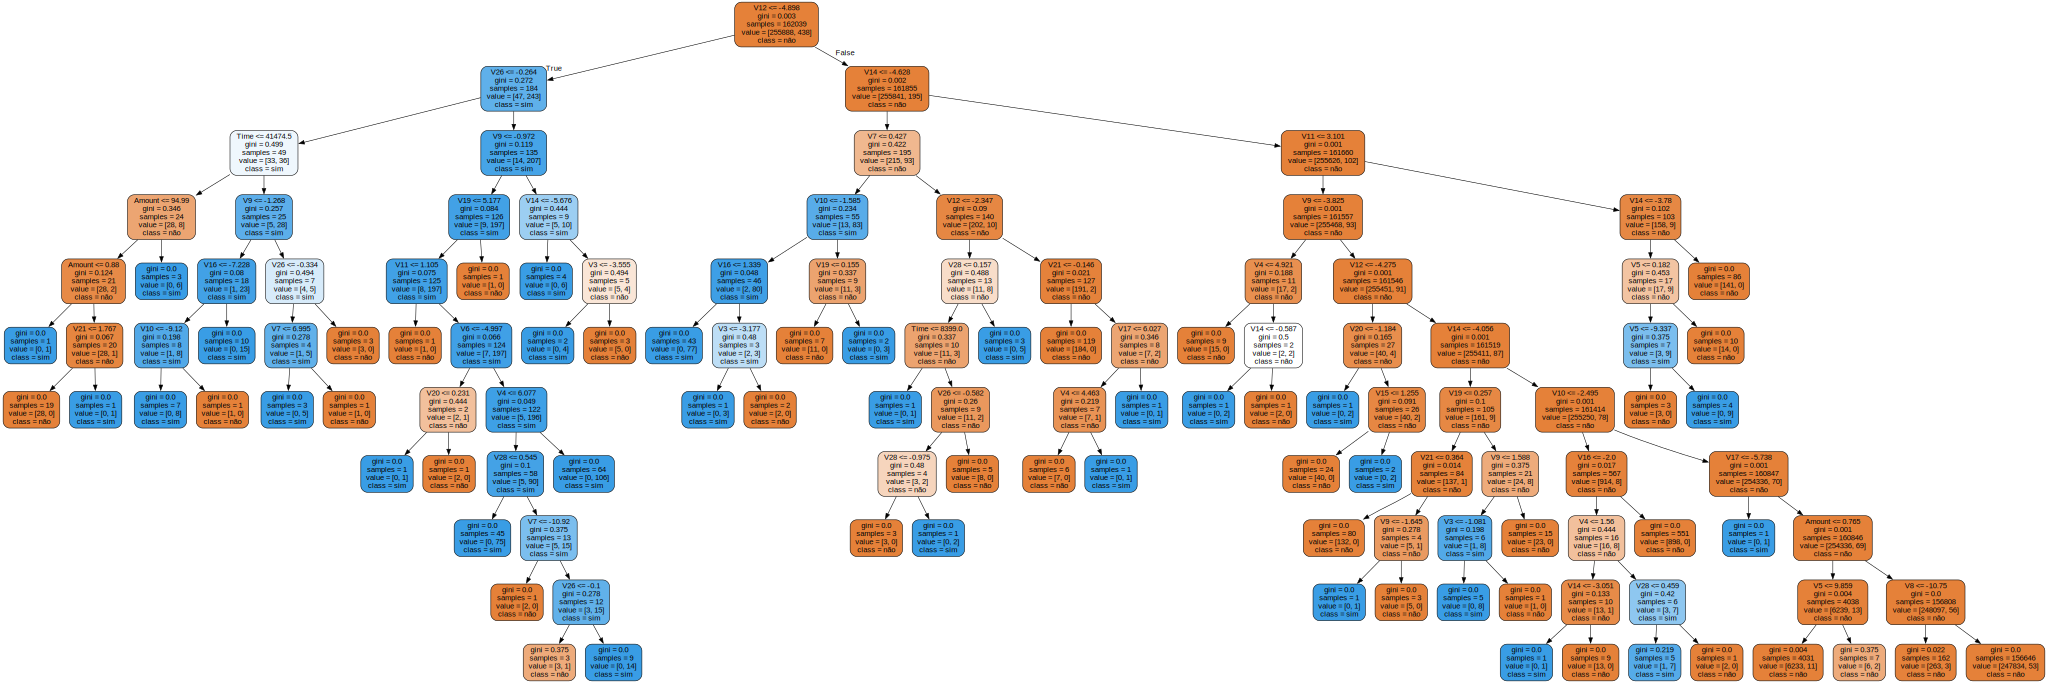

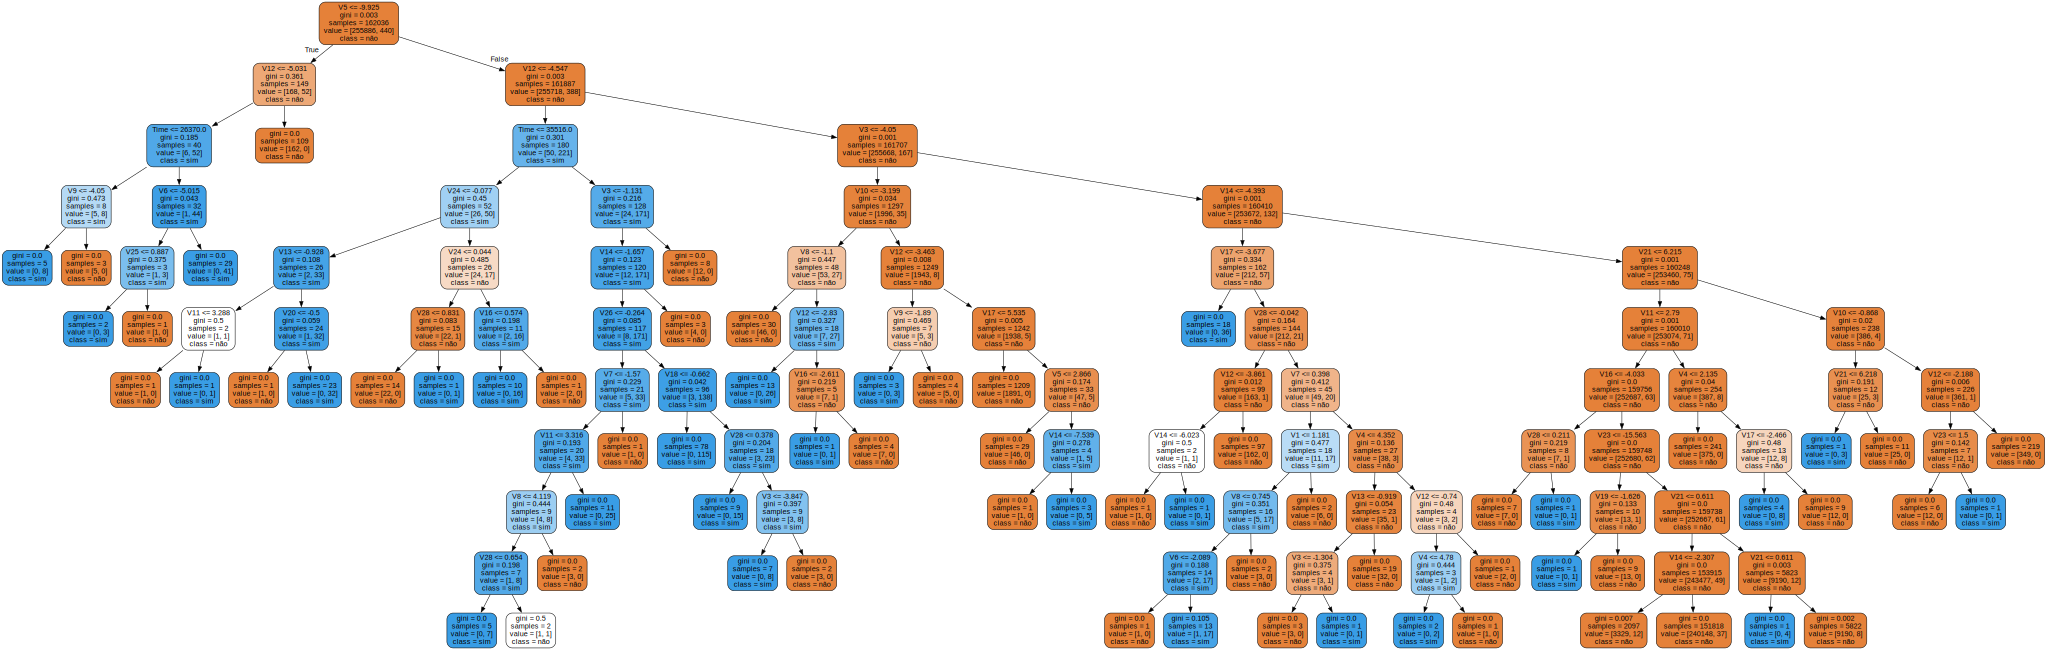

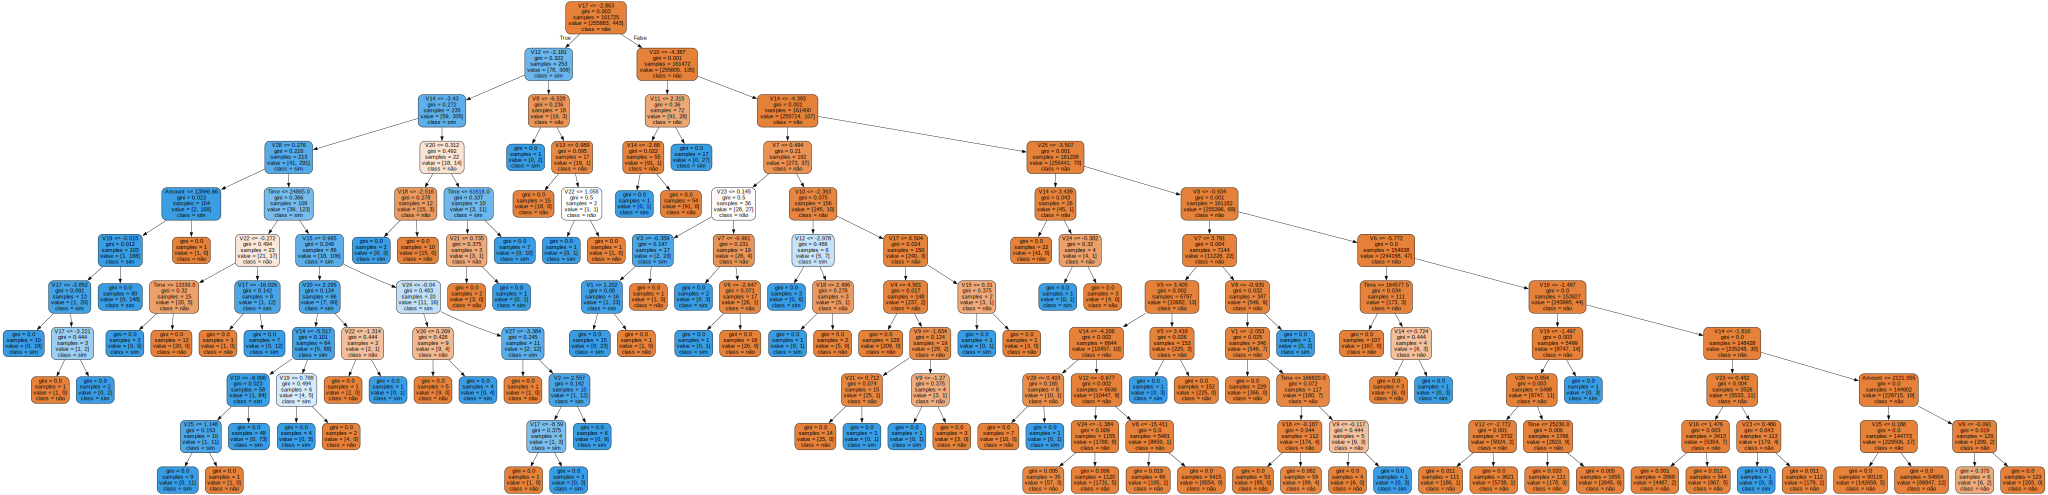

In [24]:
for tree in rand_tree_classifier.estimators_[:3]:
    graph = visualizar_arvore(tree)
    display(graph)

#### AdaBoost
A técnica boosting, diferentemente da técnica bagging que se baseava em gerar modelos independentes, ou seja, árvores independentes umas das outras. Na técnica boosting nós geramos árvores que se completam, ou seja, uma depende da outra. No geral, ela forma um modelo sequencial. Dentro da técnica boosting temos o algoritmo AdaBoost, “ada” vem de adaptativo.</br></br>
Combina múltiplos classificadores para aumentar a acurácia, árvores de pequena profundidade (chamado weak learn), ela vai tentar corrigir os erros da árvore anterior, assim é gerando um modelo sequencial de forma que um depende do outro e que um corrija os erros do anterior, até chegarmos no final e termos um bom resultado.</br></br>
O primeiro passo é selecionar um subconjunto, durante o treinamento é feito o recálculo dos pesos, conforme o modelo acerta a previsão o peso diminui, caso erre o peso é aumentado, assim é recalculado os pesos de acordo com a influência da árvore.</br></br>
O modelo não é suscetível a overffiting, mas é sensível a outliers.


In [25]:
%%time
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=SEED)

treinamento_modelo(adaboost_classifier, X_train, np.array(y_train).ravel())

fit_time: [96.88185859 95.29588556 95.39019895 94.76892209 94.270087  ]
score_time: [0.62201691 0.66300106 0.65765953 0.73093891 0.67887235]
test_score: [0.99918074 0.99933678 0.99923925 0.99921974 0.99925875]

A quantidade de splits é de 5 folds
A média dos scores é de 0.99925
O desvio padrão é de 5.1752460379897394e-05
O intervalo de confiança ficou entre 99.91% e 99.94%
CPU times: total: 7min 54s
Wall time: 8min


In [26]:
adaboost_classifier.fit(X_train, np.array(y_train).ravel())
y_pred = adaboost_classifier.predict(X_test)
avaliacao_arvore(y_test, y_pred)

,Transação normal(prev),Fraude(prev)
Transação normal,28428,4
Fraude,17,32


Acúrácia sobre os dados de teste - (28428 + 32) / 28481 =  99.9263%
Precisão somente para as transações com fraude - 32 / (4 + 32) = 88.8889%
Recall somente para as transações com fraude - 32 / (17 + 32) =  65.3061%


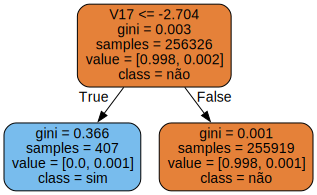

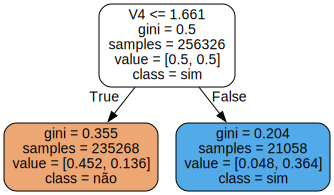

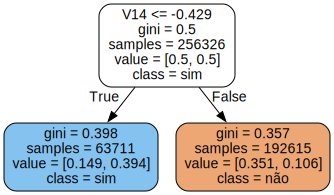

In [27]:
for tree in adaboost_classifier.estimators_[:3]:
    graph = visualizar_arvore(tree)
    display(graph)